In [3]:
from nltk.stem.porter import PorterStemmer
import json
import re
import math
from numpy import *
import numpy as np
import matplotlib.pyplot as plt

# Data Process
Read the training data to get the number of users and restaurants

In [4]:
## objectives (2)
## 1. get the number of users & items in training data (currently with size of 40,000)
## 2. get Global: mu, bias_user, bias_item

# get the size of user_id & business_id
user_id = []
business_id = []
# with open('yelp_data/yelp_testing.json') as f:
with open('yelp_data/alg_train.json') as f:
    for line in f:
        temp = json.loads(line)        
        user_id.append(temp["user_id"])
        business_id.append(temp["business_id"])
        
# print user_id.__len__()
# print business_id.__len__()

# This is without duplication: set
user_id = set(user_id)
business_id = set(business_id)

print user_id.__len__()
print business_id.__len__()
print "done"

59890
4262
done


# User and Restaurant Matching
Make "user_id" in the data match the index in latent factor model

Do the same to "business_id"

In [5]:
user_id = list(user_id)
user_idx = range(user_id.__len__())
user_match = dict(zip(user_id, user_idx))

business_id = list(business_id)
business_idx = range(business_id.__len__())
business_match= dict(zip(business_id, business_idx))

print "done"

done


# Sochastic Gradient Decent training function

In [11]:
## SGD training function interface
# inputs(10):
# ite: number of iteration
# lam: regulation factor: assume lam1 == lam2 == lam3 == lam4
# mu: study rate: assume mu1 = mu2
# k: number of concept in latent factor
# m: number of users
# n: number of items
# user_match: from user_id to index i
# business_match: from business_id to index j
# outputs(4):
# latent factor q & p, updated user_bias & business_bias
def SGD_train(file_name, ite, lam, mu, k, m, n, user_match, business_match):
    # initialization
    q = np.random.rand(m, k) * sqrt(5.0 / k)  # normalization
    p = np.random.rand(n, k) * sqrt(5.0 / k)
    fig = empty(ite)

    ## essential steps
    # 1. read the file to get user_id, business_id, stars
    # 2. find the corresponding index of user_id, business_id in q and p
    # 3. Stochastic GD alg
    for num in range(0, ite):
#         print num
        # read the file to update q & p
        with open(file_name) as f:
            for line in f:
                temp = json.loads(line)
                cur_user_id = temp["user_id"]
                cur_business_id = temp["business_id"]
                i = user_match[cur_user_id]                  # get the index of corresponding user in q
                j = business_match[cur_business_id]          # get the index of corresponding business in p
                star = temp["stars"]
                # updating p, q, b_x & b_i
                eps = 2 * (star - dot(q[i, ], p[j, ]))
                temp_q = q[i, ] + mu * (eps * p[j, ] - 2 * lam * q[i, ])
                temp_p = p[j, ] + mu * (eps * q[i, ] - 2 * lam * p[j, ])
                q[i, ] = temp_q
                p[j, ] = temp_p
    
        # read the file to calculate the error
#         error = 0
#         with open(file_name) as f:
#             for line in f:
#                 temp = json.loads(line)
#                 cur_user_id = temp["user_id"]
#                 cur_business_id = temp["business_id"]
#                 i = user_match[cur_user_id]
#                 j = business_match[cur_business_id]
#                 b_x = user_bias[cur_user_id]
#                 b_i = business_bias[cur_business_id] 
#                 star = temp["stars"]
#                 error += (star - (average + b_x + b_i + dot(q[i, ], p[j, ]))) ** 2
#         # add the regulation error (combine them in all)
#         # regulation for b_x & b_i
#         regu_user_bias = 0
#         regu_business_bias = 0
#         for key in user_bias:
#             regu_user_bias += user_bias[key] ** 2
#         for key in business_bias:
#             regu_business_bias += business_bias[key] ** 2
#         error += lam * (sum(q ** 2) + sum(p ** 2) + regu_user_bias + regu_business_bias)
#         fig[num] = error        

#     # examine: plot the graph 
#     plt.plot(range(0, ite), fig)
#     plt.show()            
#     print error             
#     print "done"
    return q, p

# Sochastic Gradient Decent testing function

In [12]:
## SGD testing function with baseline interface
# input(7):
# file_name
# q and p
# user_match & business_match
# average
# output(1):
# RMSE
def SGD_test(file_name, q, p, user_match, business_match):
    extrapolate_star = []
    origin_star = []
    size = 0
    RMSE = 0
    with open(file_name) as f:
        for line in f:
            temp = json.loads(line)
            cur_user_id = temp["user_id"]
            cur_business_id = temp["business_id"]
            # check if current review is in the Matrix
            if cur_user_id in user_match and cur_business_id in business_match:
                size += 1
                i = user_match[cur_user_id]
                j = business_match[cur_business_id]
                star = temp["stars"]
                RMSE += (star - dot(q[i, ], p[j, ])) ** 2
        RMSE = sqrt(RMSE / float(size))    
    return RMSE

# Turing Procedure
1. Regulation tuning lam from 0.1 to 0.9 with step 0.1 

0.01
1.3049932669
0.02
1.30741675619
0.03
1.30691710555
0.04
1.30037379564
0.05
1.28992721781
0.06
1.30207568009
0.07
1.29683413729
0.08
1.27921202999
0.09
1.28905947178


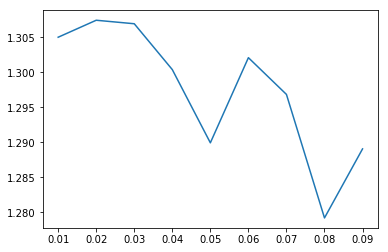

done


In [17]:
## tuning parameter
ite = 15                                  
# lam = [(x + 1) / float(10) for x in range(0, 9)]          # for turing purpose      
lam = [(x + 1) / float(100) for x in range(0, 9)]           # lam = 0.08
mu = 0.005                                
k = 20                                    
m = user_id.__len__()                     
n = business_id.__len__()        
output = empty(lam.__len__())
train_file = 'yelp_data/alg_train.json'
test_file = 'yelp_data/alg_test.json'

for cur_lam in lam:
    # training
    [q, p] = SGD_train(train_file, ite, cur_lam, mu, k, m, n, user_match, business_match)
    # testing
    RMSE = SGD_test(test_file, q, p, user_match, business_match)
    output[lam.index(cur_lam)] = RMSE
    print cur_lam
    print RMSE

plt.plot(lam, output)
plt.show()                
print "done"    